# U'n'Eye: Convolutional Neural Network for Saccade Detection
Written by Kellen Vu, using the UnEye library developed by Bellet et al.

# Training

In [283]:
import numpy as np
import uneye
import matplotlib.pyplot as plt
import scipy.io as io
import os
from os.path import join as pj
import pickle

In [337]:
# Parameters
datapath = 'data/Synthetic/'
min_sacc_dur = 6  # Saccades shorter than this (ms) are removed
min_sacc_dist = 1  # Saccades closer than this (ms) apart are merged
sampfreq = 1000 # Hz
weights_name = 'weights_synthetic'  # This name will be used when we save the weights into a file

In [336]:
# Load dataset from .mat files
example_size = 1000  # Split the data into chunks that are each __ ms long
X = None
L = None
for file in os.listdir(datapath):
    mat = io.loadmat(datapath + file)
    X_new = mat['X']
    n_t = X_new.shape[1]
    X_new = X_new[:, :n_t - n_t % example_size].reshape(-1, example_size)
    L_new = mat['L']
    L_new = L_new[:, :n_t - n_t % example_size].reshape(-1, example_size)
    if X is None:
        X = X_new
        L = L_new
    else:
        X = np.concatenate((X, X_new), axis=0)
        L = np.concatenate((L, L_new), axis=0)
Y = np.zeros(X.shape)

D:\ProgramData\Anaconda3\envs\uneye\lib\site-packages\scipy\io\matlab\mio4.py:347: RuntimeWarning: overflow encountered in long_scalars
  n = reduce(lambda x, y: x*y, hdr.dims, 1)  # fast product
D:\ProgramData\Anaconda3\envs\uneye\lib\site-packages\scipy\io\matlab\mio4.py:348: RuntimeWarning: overflow encountered in long_scalars
  remaining_bytes = hdr.dtype.itemsize * n
D:\ProgramData\Anaconda3\envs\uneye\lib\site-packages\scipy\io\matlab\mio4.py:167: RuntimeWarning: overflow encountered in long_scalars
  num_bytes *= d


ValueError: read length must be non-negative or -1

In [338]:
# Load dataset from .csv files
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'
labels_filename = 'Labels_1000hz.csv'

X = np.loadtxt(datapath + x_filename, delimiter=',')
Y = np.loadtxt(datapath + y_filename, delimiter=',')
L = np.loadtxt(datapath + labels_filename, delimiter=',')

In [314]:
# Define train set
m = X.shape[0]
m_train = round(0.7 * m)  # Use a data split of 70/15/15
m_dev = round(0.15 * m)

X_train = X[:m_train + m_dev, :]
Y_train = Y[:m_train + m_dev, :]
L_train = L[:m_train + m_dev, :]

# Define model
model = uneye.DNN(sampfreq=sampfreq,
                  weights_name=weights_name,
                  min_sacc_dur=min_sacc_dur,
                  min_sacc_dist=min_sacc_dist,
                  augmentation=True,
                  val_samples=m_dev)

In [311]:
# Train model
# Weights will automatically be saved to local folder 'training'
model.train(X_train, Y_train, L_train)

# Save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

Number of classes: 2
Using GPU: False
Training. Please wait.
Early stopping at epoch 74 before overfitting occurred.
Model parameters saved to ./training\weights_synthetic


In [278]:
# Alternatively, load pre-existing model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

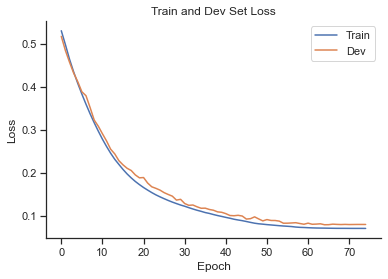

In [312]:
# Plot loss
fig, ax = plt.subplots()
ax.plot(model.loss_train, label='Train')
ax.plot(model.loss_val, label='Dev')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train and Dev Set Loss')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

# Testing

In [317]:
# TEMP
datapath = 'data/raymond/'
# Load dataset from .mat files
example_size = 1000  # Split the data into chunks that are each __ ms long
X = None
L = None
for file in os.listdir(datapath):
    mat = io.loadmat(datapath + file)
    X_new = mat['X']
    n_t = X_new.shape[1]
    X_new = X_new[:, :n_t - n_t % example_size].reshape(-1, example_size)
    L_new = mat['L']
    L_new = L_new[:, :n_t - n_t % example_size].reshape(-1, example_size)
    if X is None:
        X = X_new
        L = L_new
    else:
        X = np.concatenate((X, X_new), axis=0)
        L = np.concatenate((L, L_new), axis=0)
Y = np.zeros(X.shape)

X_test = X
Y_test = Y
L_test = L

In [339]:
# Define test set from train set
X_test = X[m_train + m_dev:, :]
Y_test = Y[m_train + m_dev:, :]
L_test = L[m_train + m_dev:, :]

In [340]:
# Test performance
prediction, probability, performance = model.test(X_test, Y_test, L_test)

Binary Cohens Kappa:  0.971
F1: 0.996


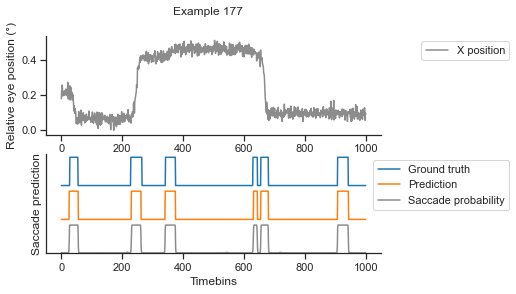

In [369]:
# Interactive plot (inline vs. qt)
%matplotlib inline

# Plot example
i = np.random.randint(X_test.shape[0])
# i = 1083
fig, ax = plt.subplots(2, 1)
fig.suptitle(f'Example {i}')
x_trace = X_test[i, :] - np.min(X_test[i, :])
y_trace = Y_test[i, :] - np.min(Y_test[i, :])
ax[0].plot(x_trace, label='X position', c='k', alpha=0.5)
ax[0].set_ylabel('Relative eye position (°)')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].legend(bbox_to_anchor=(1.4, 1))

# Prediction
ax[1].plot(L_test[i, :] + 2.4, label='Ground truth', c='tab:blue')
ax[1].plot(prediction[i, :] + 1.2, label='Prediction', c='tab:orange')
ax[1].plot(probability[i, :], label='Saccade probability', c='k', alpha=0.5)
ax[1].set_ylabel('Saccade prediction')
ax[1].set_xlabel('Timebins')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].legend(bbox_to_anchor=(1.4, 1))
ax[1].set_ylim([0, 3.5])
ax[1].set_yticks([])
plt.ion()
plt.show()

# Prediction

In [160]:
import numpy as np

##################################
########### Parameters ###########
sampfreq = 1000 #Hz
weights_name = 'weights_raymond'
min_sacc_dur = 6 # in ms
min_sacc_dist = 10 #in ms

########### YOUR DATA ############

datapath = 'data/Synthetic/' #example data
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'

##################################
##################################

# load data
Xtest = np.loadtxt(pj(datapath,x_filename),delimiter=',')
Ytest = np.loadtxt(pj(datapath,y_filename),delimiter=',')

In [182]:
import uneye
# Prediction
model = uneye.DNN(weights_name=weights_name,
                 sampfreq=sampfreq,
                 min_sacc_dur=min_sacc_dur,
                min_sacc_dist=min_sacc_dist)
Prediction,Probability = model.predict(Xtest,Ytest)

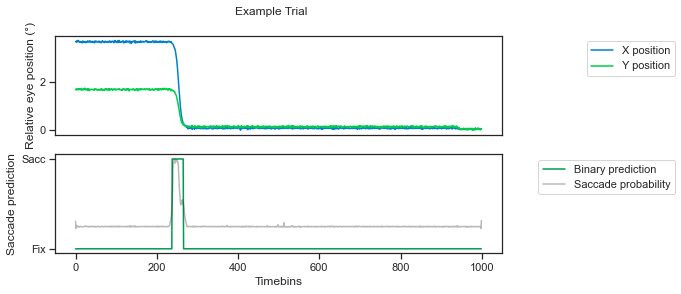

In [181]:
import matplotlib.pyplot as plt
# plot example
i = np.random.randint(Xtest.shape[0])
fig = plt.figure(figsize=(8,4))
plt.suptitle('Example Trial')
ax = fig.add_subplot(211)
x_trace = Xtest[i,:] - np.min(Xtest[i,:])
y_trace = Ytest[i,:] - np.min(Ytest[i,:])
plt.plot(x_trace,label='X position',c=[0,0.5,0.8])
plt.plot(y_trace,label='Y position',c=[0,0.8,0.3])
plt.xticks(())
plt.ylabel('Relative eye position (°)')
plt.legend(bbox_to_anchor=(1.4,1))

# prediction
ax = fig.add_subplot(212)
plt.plot(Prediction[i,:],label='Binary prediction',c=[0,0.6,0.3])
plt.plot(Probability[i,1,:],label='Saccade probability',c='k',alpha=.3)
plt.yticks((0,1),['Fix','Sacc'])
plt.ylabel('Saccade prediction')
plt.xlabel('Timebins')
plt.legend(bbox_to_anchor=(1.4,1))
plt.show()